# Trabajo 2 - 2021-2022

**Autor**: Sergio Rodríguez Calvo

In [1]:
# See: https://www.statology.org/runtimewarning-overflow-encountered-in-exp/
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

Vamos a comenzar el experimento declarando todo aquellos que vamos a necesitar a lo largo del cuaderno.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

## Elección y análisis del conjunto de datos

El conjunto de datos ejegido es [_hepatitis_](https://archive.ics.uci.edu/ml/datasets/Hepatitis), que consiste en un conjunto multivariante con 19 atributos o propiedades (de todos los tipos, esto es, categóricos y numéricos) y cuya clasificación es binaría: DIE que indica que el paciente muere; LIVE que indica que el paciente sobrevive. El conjunto de datos cuenta con un total de 155 instancias o ejemplos.

Los nombres de los atributos son los siguientes:

In [3]:
names = [   
            'class',
            'age',
            'sex',
            'steroid',
            'antivirals',
            'fatigue',
            'malaise',
            'anorexia',
            'liver_big',
            'liver_firm',
            'spleen_palpable',
            'spiders',
            'ascities',
            'varices',
            'bilirubin',
            'alk_phosphate',
            'sgot',
            'albumin',
            'protime',
            'histology'
        ]

Vamos a cargar el conjunto de datos en un _dataframe_ de Pandas.

In [4]:
missing_values = ['?']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data'
df = pd.read_csv(url, names=names, na_values=missing_values)
df_original = df.copy(deep=True)

Vamos a mostrar la información general proporcionada por el _dataframe_, donde podemos ver el número de entradas (ejemplos o instancias), los atributos, el tipo de dato de cada atributo y los valores presentes (no nulos), aunque luego mostraremos más información respecto de los valores ausentes.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            155 non-null    int64  
 1   age              155 non-null    int64  
 2   sex              155 non-null    int64  
 3   steroid          154 non-null    float64
 4   antivirals       155 non-null    int64  
 5   fatigue          154 non-null    float64
 6   malaise          154 non-null    float64
 7   anorexia         154 non-null    float64
 8   liver_big        145 non-null    float64
 9   liver_firm       144 non-null    float64
 10  spleen_palpable  150 non-null    float64
 11  spiders          150 non-null    float64
 12  ascities         150 non-null    float64
 13  varices          150 non-null    float64
 14  bilirubin        149 non-null    float64
 15  alk_phosphate    126 non-null    float64
 16  sgot             151 non-null    float64
 17  albumin         

Podemos ver también las primeras instancias del conjunto.

In [6]:
df.head()

,class,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascities,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology
0,2,30,2,1.0,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,85.0,18.0,4.0,NaN,1
1,2,50,1,1.0,2,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0.9,135.0,42.0,3.5,NaN,1
2,2,78,1,2.0,2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,96.0,32.0,4.0,NaN,1
3,2,31,1,NaN,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,46.0,52.0,4.0,80.0,1
4,2,34,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,200.0,4.0,NaN,1


## Preprocesado

Vamos a comenzar con el preprocesado, en concreto, cambiando los valores de clasificación 1 (DIE) y 2(LIVE) por 0 y 1 respectivamente, ya que es más conveniente de cara a realizar una clasificación binaria.

In [7]:
df["class"].replace((1,2),(0,1),inplace=True)

Ahora, vamos a ver la cantidad de valores ausentes por atributo. Ya hemos visto anterioremente cierta información al respecto cuando hemos ejecutado `df.info()`, pero vamos a ver la cantidad de atributos ausentes por atributo.

In [8]:
df.isnull().sum()

class               0
age                 0
sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
spiders             5
ascities            5
varices             5
bilirubin           6
alk_phosphate      29
sgot                4
albumin            16
protime            67
histology           0
dtype: int64

Otro aspecto importante es conocer si el conjunto de datos está balanceado.

In [9]:
df['class'].value_counts()

1    123
0     32
Name: class, dtype: int64

Vemos que el conjunto de datos no está balanceado, ya que tenemos 32 ejemplos clasificados como DIE (o 0) y 123 ejemplos clasificados como LIVE (o 1). A la hora de evluar diferentes modelos, debemos tener en cuenta que los datos no están balanceados respecto de su clasificación.

La primera transformación que vamos a realizar es la relativa al atributo edad. Vamos a agrupar los ejemplos por rangos de edad, sin ejecutar One-Hot para evitar la correlación, ya que en este caso es preferible dejar los rangos como una especie de categorías numéricas, para así mantener la correlación.

In [10]:
df['age'] = pd.cut(x=df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],labels=[1,2,3,4,5,6,7,8])

La segunda transformación es la relativa al campo de tipo categórico sexo, al que vamos a realizar una transformación de valores tales como, 1 para 'male' y 2 para 'female'. Posteriormente, realizamos un One-Hot adjuntando el resultado al _dataframe_ y eliminando el campo que teníamos anteriormente.

In [11]:
sex_df = pd.get_dummies(df.sex, prefix='sex')
df = pd.concat([df, sex_df], axis=1)
df.rename(columns={"sex_1": "sex_male", "sex_2": "sex_female"}, inplace=True)
df.drop(['sex'], axis=1, inplace=True)

La siguiente transformación va a ser transformar todos los atributos categóricos que vienen representados como 1 (para NO) y 2 (para SÍ), en 0 y 1 respectivamente.

In [12]:
df['steroid'].replace((1,2),(0,1),inplace=True)
df['antivirals'].replace((1,2),(0.,1.),inplace=True)
df['fatigue'].replace((1,2),(0,1),inplace=True)
df['malaise'].replace((1,2),(0,1),inplace=True)
df['anorexia'].replace((1,2),(0,1),inplace=True)
df['liver_big'].replace((1,2),(0,1),inplace=True)
df['liver_firm'].replace((1,2),(0,1),inplace=True)
df['spleen_palpable'].replace((1,2),(0,1),inplace=True)
df['spiders'].replace((1,2),(0,1),inplace=True)
df['ascities'].replace((1,2),(0,1),inplace=True)
df['varices'].replace((1,2),(0,1),inplace=True)
df['histology'].replace((1,2),(0.,1.),inplace=True)

A continuación, vamos a corregir los valores ausentes.

Los atributos de tipo categórico ausentes, van a ser reemplazados por la moda.

In [13]:
df['steroid'].fillna(df['steroid'].mode()[0], inplace=True)
df['fatigue'].fillna(df['fatigue'].mode()[0], inplace=True)
df['malaise'].fillna(df['malaise'].mode()[0], inplace=True)
df['anorexia'].fillna(df['anorexia'].mode()[0], inplace=True)
df['liver_big'].fillna(df['liver_big'].mode()[0], inplace=True)
df['liver_firm'].fillna(df['liver_firm'].mode()[0], inplace=True)
df['spleen_palpable'].fillna(df['spleen_palpable'].mode()[0], inplace=True)
df['spiders'].fillna(df['spiders'].mode()[0], inplace=True)
df['ascities'].fillna(df['ascities'].mode()[0], inplace=True)
df['varices'].fillna(df['varices'].mode()[0], inplace=True)

Para los atributos de tipo numérico ausentes, vamos a probar con dos opciones: la media y la mediana.

Vamos a definir una función que nos transforma un _dataframe_ de Pandas en un _array_ de Numpy, ya que la vamos a necesitar a lo largo de todo el experimento.

In [14]:
def from_df_to_X_y(df):
    X = df.to_numpy()[:,1:]
    y = df.to_numpy()[:,0]

    return X,y

Lo primero que vamos a hacer es probar con una versión del _dataframe_ en el que sustituimos los valores ausentes por la media.

In [15]:
df_mean = df.copy(deep=True)
df_mean['bilirubin'].fillna(df_mean['bilirubin'].mean(), inplace=True)
df_mean['alk_phosphate'].fillna(df_mean['alk_phosphate'].mean(), inplace=True)
df_mean['sgot'].fillna(df_mean['sgot'].mean(), inplace=True)
df_mean['albumin'].fillna(df_mean['albumin'].mean(), inplace=True)
df_mean['protime'].fillna(df_mean['protime'].mean(), inplace=True)

Vamos a evaluar este caso utilizando un modelo de regresión logística.

In [16]:
X, y = from_df_to_X_y(df_mean)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state=20)

lr_mean = LogisticRegression(random_state=10 ,solver='lbfgs').fit(X_train, y_train)
score = lr_mean.score(X_test,y_test)

print('El rendimiento es {:.3f}'.format(score))

El rendimiento es 0.936


Repetimos el proceso pero utilizando esta vez la mediana.

In [17]:
df_median = df.copy(deep=True)
df_median['bilirubin'].fillna(df_median['bilirubin'].median(), inplace=True)
df_median['alk_phosphate'].fillna(df_median['alk_phosphate'].median(), inplace=True)
df_median['sgot'].fillna(df_median['sgot'].median(), inplace=True)
df_median['albumin'].fillna(df_median['albumin'].median(), inplace=True)
df_median['protime'].fillna(df_median['protime'].median(), inplace=True)

In [18]:
X, y = from_df_to_X_y(df_median)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state=20)

lr_median = LogisticRegression(random_state=10 ,solver='lbfgs').fit(X_train, y_train)
score = lr_median.score(X_test,y_test)

print('El rendimiento es {:.3f}'.format(score))

El rendimiento es 0.915


El modelo con el que mejor resultado hemos obtenido es mediante la media, por lo que vamos a utilizar dicha transformacion para reemplazar los valores ausentes.

In [19]:
df['bilirubin'].fillna(df['bilirubin'].mean(), inplace=True)
df['alk_phosphate'].fillna(df['alk_phosphate'].mean(), inplace=True)
df['sgot'].fillna(df['sgot'].mean(), inplace=True)
df['albumin'].fillna(df['albumin'].mean(), inplace=True)
df['protime'].fillna(df['protime'].mean(), inplace=True)

Una vez realizadas todo el preprocesamiento, vamos a echar un vistazo tanto a las primeras instancias del conjunto, así como comprobar que efectivamente ya no quedan más valores nulos en el _dataframe_.

In [20]:
df.head()

,class,age,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,...,ascities,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,sex_male,sex_female
0,1,3,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,85.000000,18.0,4.0,61.852273,0.0,0,1
1,1,5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.9,135.000000,42.0,3.5,61.852273,0.0,1,0
2,1,8,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.7,96.000000,32.0,4.0,61.852273,0.0,1,0
3,1,4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.7,46.000000,52.0,4.0,80.000000,0.0,1,0
4,1,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,105.325397,200.0,4.0,61.852273,0.0,1,0


In [21]:
df.isnull().sum()

class              0
age                0
steroid            0
antivirals         0
fatigue            0
malaise            0
anorexia           0
liver_big          0
liver_firm         0
spleen_palpable    0
spiders            0
ascities           0
varices            0
bilirubin          0
alk_phosphate      0
sgot               0
albumin            0
protime            0
histology          0
sex_male           0
sex_female         0
dtype: int64

In [22]:
X_data, y_data = from_df_to_X_y(df)
X_names = df.columns[1:]

## Selección de atributos

Vamos a comenzar la selección de atributos para obtener un conjunto de datos con menos atributos, lo que mejorará el rendimiento de los modelos, mostrando una representación gráfica conjunta de las instancias según su clasificación. Esta es una forma visual de ver si los conjuntos presentan una clara diferenciación según su clasificación.

Vamos a seleccionar sólo los atributos numéricos, ya que de otra forma no vamos a obtener una imagen del tamaño adecuado con los 20 atributos.

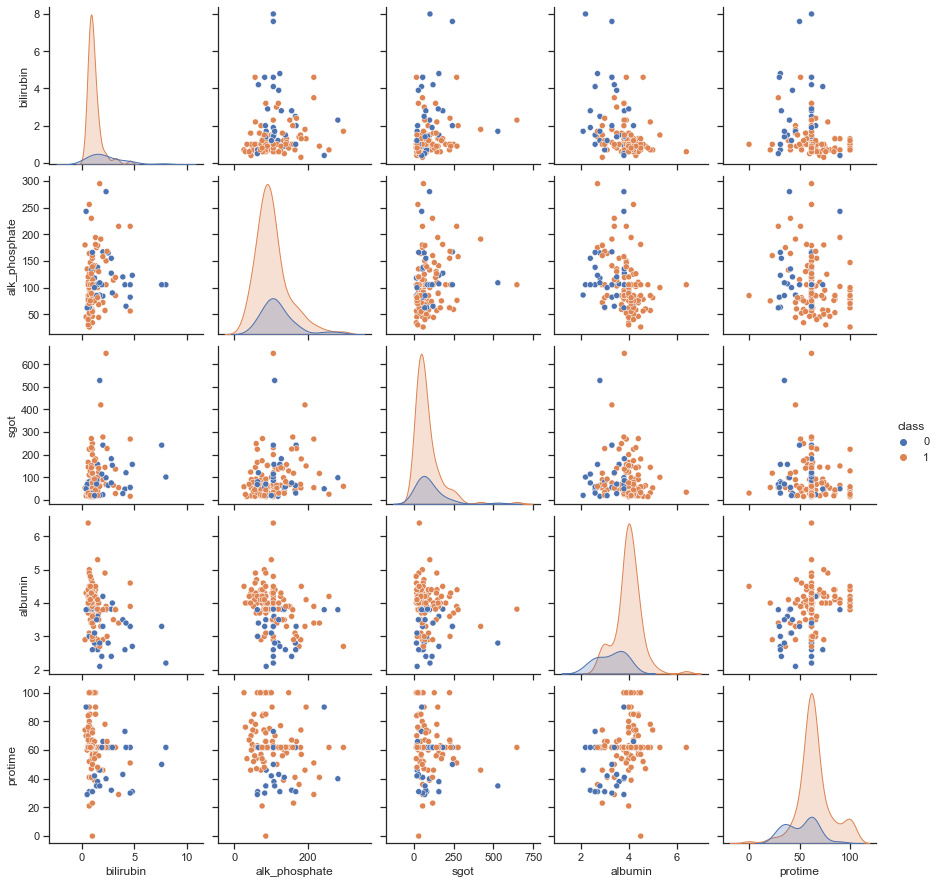

In [23]:
selected = ['class','bilirubin','alk_phosphate','sgot','albumin','protime']
sns.pairplot(df[selected], hue='class')

Además, de estos mismos atributos, vamos a estudiar la correlación que hay entre ellos y con respecto al atributo de clasificación.

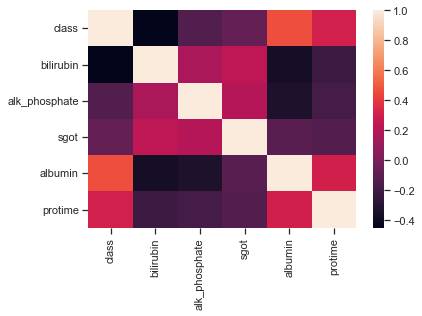

In [24]:
def correlation_heatmap(corr):
    ax = sns.heatmap(corr)

num_corr = df[selected].corr()
correlation_heatmap(num_corr)

Vemos en la leyenda que el color más blanco (más cercano a un valor 1) que significa que los atributos están correlados, de forma que cuando uno crece el otro también crece. El color negro (más cercano a -1) también significa correlación, pero por el contrario cuando un atributo crece el otro decrece. Con un color morado (más cercano a 0), sabemos que los atributos no están correlados.

Por tanto, vemos que el atributo `bilirubin` está correlado con el valor de clasificación de forma descendente o, por el contrario, vemos que `alk_phosphate` y `sgot` no están correlados con el valor de clasificación.

### Eliminación recursiva de características

Vamos a utilizar la eliminación recursiva de características, que es una técnica de selección de características que consiste en construir modelos de decisión con el conjunto de datos original al que se ha quitado una característica y cuyo proceso termina cuando se ha llegado a un número de características objetivo o mientras que se obtengan modelos que mejoren el rendimiento.

De esta forma, reducimos el número de atributos del conjunto de datos y, para ello, vamos a usar la función que se desarrolló para el ejercicio de _Preprocesado e ingeniería de características_.

In [25]:
def eliminacion_recursiva(X, y, X_names, n_target=1, verbose=0, random_state=0):
    stop = False # To be able to stop the loop once there is no improve
    best_score = LogisticRegression(random_state=random_state, multi_class='multinomial', solver='lbfgs').fit(X, y).score(X,y)
    X_data = np.copy(X)
    names = np.copy(X_names)

    while not stop and X_data.shape[1] > n_target:
        best_i = -1

        for i in range(X_data.shape[1]):
            X_tmp = np.concatenate((X_data[:,:i],X_data[:,i+1:]), axis=1)
            tmp_score = LogisticRegression(random_state=random_state, solver='lbfgs').fit(X_tmp, y).score(X_tmp, y)

            if tmp_score > best_score:
                best_score = tmp_score
                best_i = i
            
        if best_i >= 0:
            names = np.copy(np.concatenate((names[:best_i],names[best_i+1:]), axis=None))
            X_data = np.concatenate((X_data[:,:best_i],X_data[:,best_i+1:]), axis=1)
        else:
            stop = True
    
    if verbose:
        print("Dataset shape result: ", X_data.shape)
        print("Remaining names: ", names)
    
    return (X_data, names)

In [26]:
X1_data, X1_names = eliminacion_recursiva(X_data, y_data, X_names)

print("Características restantes: ", X1_names)
removed = [item for item in X_names if item not in X1_names]
print("Características eliminadas: ", removed)
print("Numero de características eliminadas: ", len(names) - len(X1_names))
print("Forma del dataset resultante: ", X1_data.shape)

Características restantes:  ['steroid' 'antivirals' 'fatigue' 'malaise' 'anorexia' 'liver_big'
 'liver_firm' 'spleen_palpable' 'spiders' 'ascities' 'varices' 'bilirubin'
 'alk_phosphate' 'sgot' 'protime' 'histology' 'sex_male' 'sex_female']
Características eliminadas:  ['age', 'albumin']
Numero de características eliminadas:  2
Forma del dataset resultante:  (155, 18)


# Evaluación de modelos

Vamos a proceder a utilizar diferentes modelos y a evluar cada uno de ellos para, finalmente, elegir el que obtengamos el mejor rendimiento.

En primer lugar, vamos a dividir los datos en un conjunto de entrenamiento y en otro conjunto para pruebas, con el fin de medir el rendimiento. Vamos a partir de la elección de características obtenidas anteriormente, ya que vamos a trabajar con un conjunto más pequeño en términos de atributos. Con ello, vamos a compensar la ganada de rendimiento al trabajar con menor cantidad de atributos, con el utilizar técnicas como validación cruzada, que tienen un coste de ejecución algo mayor.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X1_data,y_data,test_size = 0.33,random_state=4861,stratify=y_data)

Además, estamos trabajando con propiedades que no tienen nada en común, por lo que vamos a realizar una normalización de los datos para evitar que el modelo encuentre relaciones o características que no nos interesan. Algunas, ya las hemos abordado al inicio con el preprocesamiento, pero también es conveniente hacerlo antes de proceder a probar diferentes modelos.

In [28]:
min_max_scaler = MinMaxScaler()
Xt_train = min_max_scaler.fit_transform(X_train)
Xt_test = min_max_scaler.transform(X_test)

Antes de pasar a evaluar modelos, vamos a definir una función que nos va a hacer el trabajo por nosotros. Vamos a utilizar `GridSearchCV` que es una clase que permite realizar la validación cruzada para encontrar los mejores parámetros (o hiperparámetros) para cada modelo entre un conjunto de parámetros dado. Además, vamos a utilizar la métrica F1, que combina las métricas precisión y _recall_ mediante una media ármónica.

Las métricas precisión y _recall_ consisten obtener unas métricas a partir de lo obtenido en una matriz de confusión, ideal para nuestro caso al tratarse de clasificación binaria. Son métricas más exhaustivas, sobre todo _recall_.

In [29]:
def scores(estimator, params):
    grid_search = GridSearchCV(estimator(), param_grid=params, cv=5, return_train_score=True, scoring='f1')
    grid_search.fit(Xt_train, y_train)
    
    print('Media de los mejor resultados en validación cruzada: {:.3f}'.format(grid_search.best_score_))
    print('Mejor clasificador encontrado: {}'.format(grid_search.best_estimator_))
    print('Evaluación sobre el conjunto de test: {:.3f}'.format(grid_search.score(Xt_test, y_test)))

    print('')
    print('Reporte de clasificación:')
    print(classification_report(y_test, grid_search.predict(Xt_test), target_names=['Die','Live']))

Cabe destacar, que vamos a dar también un rendimiento de tipo _accuracy_, es decir, proporción de aciertos, independienmente de lo que obtengamos en la función anterior.

Los modelos que vamos a utilizar son una selección de todos los que hemos visto, en su mayoría, modelos enfocados en clasificación binaria.

## K-NN

El primer modelo que vamos a utilizar es el de los vecinos más cercanos. Aunque, en realidad, se trata más bien de un algoritmo en vez de un modelo. Vamos a utilizar los parámetros más relevantes.

In [30]:
param_grid = {
    'p' : [1,2],
    'n_neighbors': list(range(2,19)),
    'weights': ['uniform', 'distance'],
}

scores(KNeighborsClassifier, param_grid)

Media de los mejor resultados en validación cruzada: 0.903
Mejor clasificador encontrado: KNeighborsClassifier(n_neighbors=7, p=1)
Evaluación sobre el conjunto de test: 0.876

Reporte de clasificación:
              precision    recall  f1-score   support

         Die       0.50      0.18      0.27        11
        Live       0.81      0.95      0.88        41

    accuracy                           0.79        52
   macro avg       0.66      0.57      0.57        52
weighted avg       0.75      0.79      0.75        52



La media de mejores resultados en validación cruzada es de aproximadamente `0.9`, obteniendo que el mejor resultado es con 7 vecinos. El parámetro distancia (o `p`) es 1, lo cual tiene sentido, ya que se usa con propiedades que no tienen relación en común, como es el caso.

La métrica que nos interesa es F1, debido a que relaciona `precision` y `recall`, obteniendo un resultado de `0.79`.

Finalmente, sobre el conjunto de pruebas obtenemos un `0.876` de rendimiento utilizando el modelo con mejor rendimiento.

## Árboles de decisión

In [31]:
param_grid = {
    'random_state': [10],
    'criterion': ['entropy','gini'],
    'max_depth': list(range(3,10)),
}
scores(DecisionTreeClassifier, param_grid)

Media de los mejor resultados en validación cruzada: 0.874
Mejor clasificador encontrado: DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10)
Evaluación sobre el conjunto de test: 0.914

Reporte de clasificación:
              precision    recall  f1-score   support

         Die       0.67      0.73      0.70        11
        Live       0.93      0.90      0.91        41

    accuracy                           0.87        52
   macro avg       0.80      0.81      0.80        52
weighted avg       0.87      0.87      0.87        52



La media de mejores resultados en validación cruzada es de aproximadamente `0.87`, obteniendo que el mejor resultado es con el criterio entropía y una profundidad máxima de 3.

La métrica que nos interesa es F1, debido a que relaciona `precision` y `recall`, obteniendo un resultado de `0.87`, que a pesar de estar ante un conjunto no balanceado, mejora al algoritmo KNN.

Finalmente, sobre el conjunto de pruebas obtenemos un `0.914` de rendimiento utilizando el modelo con mejor rendimiento.

Vamos a mostrar el árbol de decisión obtenido de forma visual.

In [32]:
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10).fit(Xt_train,y_train)
score = tree_clf.score(Xt_test,y_test)

print("El rendimiento es {:.3f}".format(score))

El rendimiento es 0.865


In [33]:
export_graphviz(
    tree_clf,
    out_file="hepatitis_tree1.dot",
    feature_names=X1_names,
    rounded=True,
    filled=True)

In [34]:
!dot -Tpng hepatitis_tree1.dot -o hepatitis_tree1.png

<Figure size 432x288 with 0 Axes>

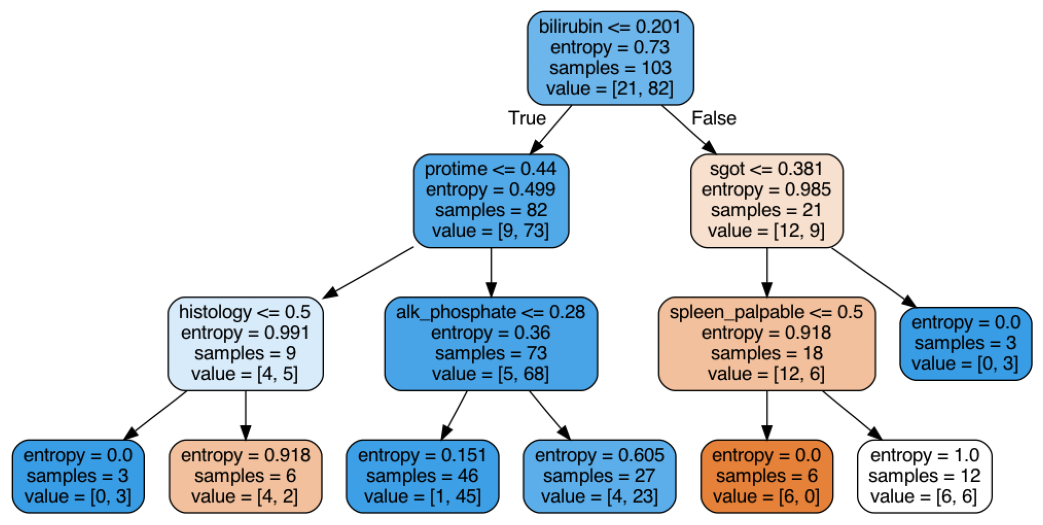

In [35]:
plt.clf()
image = plt.imread("hepatitis_tree1.png")
height, width, depth = image.shape
dpi = 70
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
plt.axis('off')
plt.imshow(image)
plt.show()

## Ensemble learning con árboles de decisión

In [36]:
param_grid = {
    'random_state': [10],
    'n_estimators': [5, 7, 10],
    'criterion': ['entropy','gini'],
    'max_depth': list(range(3,10)),
}
scores(RandomForestClassifier, param_grid)

Media de los mejor resultados en validación cruzada: 0.881
Mejor clasificador encontrado: RandomForestClassifier(max_depth=6, n_estimators=7, random_state=10)
Evaluación sobre el conjunto de test: 0.902

Reporte de clasificación:
              precision    recall  f1-score   support

         Die       0.64      0.64      0.64        11
        Live       0.90      0.90      0.90        41

    accuracy                           0.85        52
   macro avg       0.77      0.77      0.77        52
weighted avg       0.85      0.85      0.85        52



En este caso, estamos ante un meta-estimador, el cual ajusta una serie de árboles en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste.

La media de mejores resultados en validación cruzada es de aproximadamente `0.88`, obteniendo que el mejor resultado es con el criterio de Gini y una profundidad máxima de 6.

La métrica que nos interesa es F1, debido a que relaciona `precision` y `recall`, obteniendo un resultado de `0.85`, que a pesar de estar ante un conjunto no balanceado, mejora al algoritmo KNN pero es un poco peor que el árbol obtenido anteriormente.

Finalmente, sobre el conjunto de pruebas obtenemos un `0.9` de rendimiento utilizando el modelo con mejor rendimiento.

## Modelos lineales

Ahora toca el turno de los modelos lineales. En este caso, además, tenemos el parámetro 

### Regresión logística

In [37]:
param_grid = {
    'random_state': [10],
    'penalty': ['none','l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1]
}
scores(LogisticRegression, param_grid)

Media de los mejor resultados en validación cruzada: 0.897
Mejor clasificador encontrado: LogisticRegression(C=1, random_state=10)
Evaluación sobre el conjunto de test: 0.929

Reporte de clasificación:
              precision    recall  f1-score   support

         Die       0.78      0.64      0.70        11
        Live       0.91      0.95      0.93        41

    accuracy                           0.88        52
   macro avg       0.84      0.79      0.81        52
weighted avg       0.88      0.88      0.88        52



La media de mejores resultados en validación cruzada es de aproximadamente `0.9`, obteniendo que el mejor resultado es con regularización `l2` y con el parámetro inverso de la regularización a `1`.

La métrica que nos interesa es F1, debido a que relaciona `precision` y `recall`, obteniendo un resultado de `0.88`, que a pesar de estar ante un conjunto no balanceado, mejora a los modelos anterioes.

Finalmente, sobre el conjunto de pruebas obtenemos un `0.93` de rendimiento utilizando el modelo con mejor rendimiento.

### Modelos lineales SVC

In [38]:
param_grid = {
    'random_state': [10],
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}
scores(LinearSVC, param_grid)

Media de los mejor resultados en validación cruzada: 0.898
Mejor clasificador encontrado: LinearSVC(C=1, random_state=10)
Evaluación sobre el conjunto de test: 0.918

Reporte de clasificación:
              precision    recall  f1-score   support

         Die       0.75      0.55      0.63        11
        Live       0.89      0.95      0.92        41

    accuracy                           0.87        52
   macro avg       0.82      0.75      0.77        52
weighted avg       0.86      0.87      0.86        52



Los resultados en este caso son practicamente identicos al de regresión logística.

## Redes Neuronales

In [39]:
param_grid = {
    'random_state': [10],
    'solver': ['lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1],
}
scores(MLPClassifier, param_grid)

Media de los mejor resultados en validación cruzada: 0.890
Mejor clasificador encontrado: MLPClassifier(alpha=0.1, learning_rate_init=1, random_state=10, solver='sgd')
Evaluación sobre el conjunto de test: 0.927

Reporte de clasificación:
              precision    recall  f1-score   support

         Die       0.73      0.73      0.73        11
        Live       0.93      0.93      0.93        41

    accuracy                           0.88        52
   macro avg       0.83      0.83      0.83        52
weighted avg       0.88      0.88      0.88        52



El perceptron multicapa es, en la práctica, una regresión logística. Y los resultados son muy similares en cuanto a rendimiento.

Cabe destacar que el mejor resultado se ha obtenido utilizando como `solver` el descenso por gradiente estocástico.

Aunque los mejores resultados se han obtenido con los modelos lineales, si tenemos que señalar un modelo por encima del resto, sería el modelo basado en regresión logística, ya que tanto el modelo como el proceso de entrenamiento, es menos pesado que el de una red neuronal, aunque esto dependerá de la cantidad de capas y neuronas de la misma.